## Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

![alt text](images/download.png)

In [1]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
llm=ChatGroq(model="qwen-2.5-32b")

In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display

class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [8]:
def generate(state:State):
    msg=llm.invoke(f"Write a short joke about {state['topic']}")
    return {'joke':msg.content}

def improve(state:State):
    msg=llm.invoke(f"create a better joke using wordplay on the topic:{state['topic']}")
    return {'improved_joke':msg.content}

def polish(state:State):
    msg=llm.invoke(f"add a twist to this joke: {state['improved_joke']}")
    return {'final_joke':msg.content}

def gate_function(state:State):
    if "!" in state['joke'] or "?" in state['joke']:
        return "Fail"
    else:
        return "Pass"
    

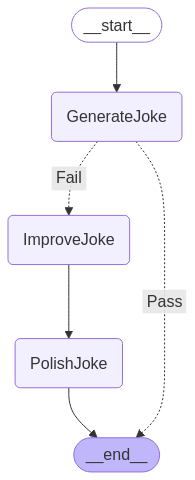

In [9]:
workflow=StateGraph(State)
workflow.add_node("GenerateJoke",generate)
workflow.add_node("ImproveJoke",improve)
workflow.add_node("PolishJoke",polish)
workflow.add_edge(START,"GenerateJoke")
workflow.add_edge("ImproveJoke","PolishJoke")
workflow.add_edge("PolishJoke",END)
workflow.add_conditional_edges("GenerateJoke",gate_function,{"Pass":END,"Fail":"ImproveJoke"})
chain = workflow.compile()
display(Image(chain.get_graph().draw_mermaid_png()))

In [10]:
state = chain.invoke({"topic": "Engineers"})

In [13]:
print("Joke:",state['joke'],"\nImproved Joke:",state['improved_joke'],"\nFinal Joke:",state['final_joke'])

Joke: Why did the engineer break up with the physicist?

Because he could never find the constants in their relationship! 
Improved Joke: Why did the engineer refuse to go on a boat ride?

Because he didn't want to risk the mechanical issues that come with being "under the engine." 
Final Joke: Why did the engineer refuse to go on a boat ride?

Because he didn't want to risk the mechanical issues that come with being "under the engine." Especially not when it could turn him into a "floating support," keeping the boat afloat by holding down the very problems he was trying to avoid!
